# Process Weather & Demand Profiles

Pre-process raw ERA5 reanalysis data, RCP 4.5 climate projections, and
ENTSO-E / GB demand data into analysis-ready datasets.

**Contents**

| Section | Description |
|---------|-------------|
| 1 | Imports |
| 2 | ERA5 variable reference |
| 3 | ERA5 raw data extraction (per variable, per year) |
| 4 | Merge per-variable files into combined yearly datasets |
| 5 | Generate analysis-ready ERA5 subsets |
| 6 | RCP 4.5 climate projections |
| 7 | Demand data processing (ENTSO-E & GB) |

## 1. Imports

In [1]:
import json
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), ".."))
from data_config import *
from utils.heat_flow_utils import (
    calculate_relative_humidity,
    calculate_specific_humidity,
)

## 2. ERA5 Variable Reference

| Variable Name | ERA5 Official Name | Code | Unit | Description |
|---|---|---|---|---|
| pressure | Surface pressure | sp | Pa | Surface pressure |
| temperature | 2m temperature | t2m | K | Air temperature 2 m above the surface |
| soil temperature | Soil temperature level 4 | stl4 | K | Soil temperature 1–3 m depth |
| influx_toa | TOA incident solar radiation | tisr | W/m² | Top-of-atmosphere solar radiation |
| influx_direct | Total sky direct solar radiation | fdir | W/m² | Direct solar radiation at surface |
| runoff | Runoff | ro | m | Volume of water runoff per unit area |
| roughness | Forecast surface roughness | fsr | m | Surface roughness length |
| height | Geopotential | z | m | Surface elevation above sea level |
| albedo | Forecast albedo | fal | – | Diffuse-reflection ratio (0–1) |
| influx_diffuse | ssrd − fdir | ssrd − fdir | W/m² | Diffuse solar radiation at surface |
| wnd100m | 100 m wind speed | √(u100² + v100²) | m/s | Wind speed at 100 m (from u/v) |

## 3. ERA5 Raw Data Extraction

Raw CDS downloads are split across up to 10 chunk files per variable.
Each chunk is opened, sliced by calendar year, and saved as a
standardised NetCDF with ``(time, y, x)`` coordinates.

The helper generator below factors out the boiler-plate that was
previously duplicated across every variable.

In [ ]:
def extract_yearly_slices(raw_folder, step_type='instant'):
    """Iterate over raw CDS chunk files and yield standardised yearly slices.

    Parameters
    ----------
    raw_folder : str
        Sub-folder name under ``EXTERNAL/era5/`` (e.g. ``'10mwind'``).
    step_type : str
        CDS step type — ``'instant'`` or ``'accum'``.

    Yields
    ------
    year : int
        Calendar year of the slice.
    raw_slice : xarray.Dataset
        Original CDS variables, sliced and latitude-flipped.
    std_ds : xarray.Dataset
        Empty Dataset with standardised ``(time, y, x)`` coordinates,
        ready for variable-specific arrays to be added.
    """
    for k in range(1, 11):
        path = (EXTERNAL
                + f'/era5/{raw_folder}/'
                + f'data_stream-oper_stepType-{step_type}-{k}.nc')
        ncfile = xr.open_dataset(path)
        year_start = int(str(ncfile.valid_time.data[0])[:4])
        year_end = int(str(ncfile.valid_time.data[-1])[:4])
        print(f'  Chunk {k}: {year_start}–{year_end}')

        for year in range(year_start, year_end + 1):
            raw_slice = ncfile.sel(
                valid_time=slice(datetime(year, 1, 1),
                                 datetime(year, 12, 31, 23)),
            ).isel(latitude=slice(None, None, -1))

            std_ds = xr.Dataset(
                coords={
                    'time': raw_slice.valid_time.data,
                    'y': raw_slice.latitude.data,
                    'x': raw_slice.longitude.data,
                },
                attrs={'module': ['era5']},
            )
            yield year, raw_slice, std_ds

### 3.1 Wind (10 m & 100 m)

In [ ]:
# 10-m wind speed + azimuth
for year, raw, ds in extract_yearly_slices('10mwind'):
    ds['wnd10m'] = xr.DataArray(
        np.sqrt(raw['u10'] ** 2 + raw['v10'] ** 2).data,
        dims=raw.dims, coords=raw.coords,
    )
    # Azimuth: north = 0, east = 90, south = 180, west = 270
    azimuth = (np.rad2deg(np.arctan2(-raw['u10'], -raw['v10'])) + 360) % 360
    ds['wnd_azimuth'] = xr.DataArray(
        azimuth.data, dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/10mwind/era5_wnd10m_data_{year}.nc')

# 100-m wind speed
for year, raw, ds in extract_yearly_slices('100mwind'):
    ds['wnd100m'] = xr.DataArray(
        np.sqrt(raw['u100'] ** 2 + raw['v100'] ** 2).data,
        dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/100mwind/era5_wnd100m_data_{year}.nc')

### 3.2 Temperature

In [ ]:
for year, raw, ds in extract_yearly_slices('temperature'):
    ds['temperature'] = xr.DataArray(
        raw['t2m'].data, dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/temperature/era5_temperature_data_{year}.nc')

### 3.3 Humidity

Relative and specific humidity are derived from 2-m temperature (``t2m``)
and 2-m dewpoint temperature (``d2m``) using functions from
``heat_flow_utils``.

In [ ]:
for year, raw, ds in extract_yearly_slices('temperature'):
    t2m = raw['t2m'].data
    d2m = raw['d2m'].data
    ds['relative_humidity'] = xr.DataArray(
        calculate_relative_humidity(t2m, d2m),
        dims=raw.dims, coords=raw.coords,
    )
    ds['specific_humidity'] = xr.DataArray(
        calculate_specific_humidity(t2m, d2m),
        dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/humidity/era5_humidity_data_{year}.nc')

### 3.4 Solar Radiation

Accumulated fields are converted from J/m² to W/m² by dividing by 3600
(one-hour accumulation period).

In [ ]:
# TOA incident solar radiation
for year, raw, ds in extract_yearly_slices('total_solar', step_type='accum'):
    ds['influx_toa'] = xr.DataArray(
        raw.tisr.data / 3600,
        dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/solar/era5_influx_toa_data_{year}.nc')

# Surface direct solar radiation
for year, raw, ds in extract_yearly_slices('surface_solar', step_type='accum'):
    ds['influx'] = xr.DataArray(
        raw.cdir.data / 3600,
        dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/solar/era5_influx_data_{year}.nc')

### 3.5 Surface Properties (Albedo & Roughness)

In [ ]:
for year, raw, ds in extract_yearly_slices('albedo_fsr'):
    ds['roughness'] = xr.DataArray(
        raw.fsr.data, dims=raw.dims, coords=raw.coords,
    )
    ds['albedo'] = xr.DataArray(
        raw.fal.data, dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/albedo_fsr/era5_surface_data_{year}.nc')

### 3.6 Runoff

In [ ]:
for year, raw, ds in extract_yearly_slices('runoff', step_type='accum'):
    ds['runoff'] = xr.DataArray(
        raw.sro.data, dims=raw.dims, coords=raw.coords,
    )
    ds.to_netcdf(EXTERNAL + f'/era5/runoff/era5_runoff_data_{year}.nc')

## 4. Merge Per-Variable Files into Yearly Datasets

Combine all per-variable NetCDF files for each year into a single
``era5_weather_data_{year}.nc`` containing every field.

In [ ]:
VARIABLE_PATHS = {
    'wnd10m':      ('10mwind',    'era5_wnd10m_data'),
    'wnd100m':     ('100mwind',   'era5_wnd100m_data'),
    'temperature': ('temperature','era5_temperature_data'),
    'humidity':    ('humidity',   'era5_humidity_data'),
    'influx':      ('solar',     'era5_influx_data'),
    'influx_toa':  ('solar',     'era5_influx_toa_data'),
    'runoff':      ('runoff',    'era5_runoff_data'),
    'surface':     ('albedo_fsr','era5_surface_data'),
}

for year in range(2015, 2025):
    print(f'Processing year {year}')

    # Open each per-variable file
    w10  = xr.open_dataset(EXTERNAL + f'/era5/10mwind/era5_wnd10m_data_{year}.nc')
    w100 = xr.open_dataset(EXTERNAL + f'/era5/100mwind/era5_wnd100m_data_{year}.nc')
    temp = xr.open_dataset(EXTERNAL + f'/era5/temperature/era5_temperature_data_{year}.nc')
    hum  = xr.open_dataset(EXTERNAL + f'/era5/humidity/era5_humidity_data_{year}.nc')
    sol  = xr.open_dataset(EXTERNAL + f'/era5/solar/era5_influx_data_{year}.nc')
    toa  = xr.open_dataset(EXTERNAL + f'/era5/solar/era5_influx_toa_data_{year}.nc')
    run  = xr.open_dataset(EXTERNAL + f'/era5/runoff/era5_runoff_data_{year}.nc')
    sfc  = xr.open_dataset(EXTERNAL + f'/era5/albedo_fsr/era5_surface_data_{year}.nc')

    # Build merged dataset
    merged = xr.Dataset(
        coords={
            'time': temp.time.data,
            'y': temp.latitude.data,
            'x': temp.longitude.data,
        },
        attrs={'module': ['era5']},
    )
    merged['wnd10m']      = xr.DataArray(w10.wnd10m.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['wnd_azimuth'] = xr.DataArray(w10.wnd_azimuth.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['wnd100m']     = xr.DataArray(w100.wnd100m.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['temperature'] = xr.DataArray(temp.temperature.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['humidity']    = xr.DataArray(hum.specific_humidity.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['influx']      = xr.DataArray(sol.influx.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['influx_toa']  = xr.DataArray(toa.influx_toa.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['runoff']      = xr.DataArray(run.runoff.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['roughness']   = xr.DataArray(sfc.roughness.data,
                                         dims=merged.dims, coords=merged.coords)
    merged['albedo']      = xr.DataArray(sfc.albedo.data,
                                         dims=merged.dims, coords=merged.coords)

    merged.to_netcdf(EXTERNAL + f'/era5/era5_weather_data_{year}.nc')

## 5. Generate Analysis-Ready ERA5 Subsets

| Dataset | Time span | Resolution | Purpose |
|---------|-----------|------------|---------|
| Daily averages | 2015–2024 | daily | Demand calibration |
| Summer hourly | 2019–2024 (Jun–Aug) | hourly | Heatwave identification |

### 5.1 Daily Averages for Demand Calibration

In [ ]:
weather_list = []
for year in range(2015, 2025):
    print(f'Processing year {year}')
    nc = xr.open_dataset(EXTERNAL + f'/era5/era5_weather_data_{year}.nc')
    weather_list.append(nc.resample(time='1D').mean())

daily_nc = xr.concat(weather_list, dim='time')
daily_nc.to_netcdf(EXTERNAL + f'/era5/era5_daily_avg_{2015}_{2024}.nc')

### 5.2 Hourly Summer Data for Heatwave Identification

In [ ]:
weather_list = []
for year in range(2019, 2025):
    print(f'Processing year {year}')
    nc = xr.open_dataset(EXTERNAL + f'/era5/era5_weather_data_{year}.nc')
    weather_list.append(nc.sel(time=nc.time.dt.month.isin([6, 7, 8])))

summer_nc = xr.concat(weather_list, dim='time')
summer_nc.to_netcdf(EXTERNAL + f'/era5/era5_hourly_summer_{2019}_{2024}.nc')

## 6. RCP 4.5 Climate Projections

Process EURO-CORDEX bias-adjusted 3-hourly fields (RCP 4.5,
CCLM4-8-17 / MPI-ESM-LR) into the same ``(time, y, x)`` layout used
for ERA5.

In [ ]:
# Spatial bounding box (Europe) — matches ERA5 extraction
RCP45_BOUNDS = {
    'x_min': -12.0, 'x_max': 45.0,
    'y_min': 33.0,  'y_max': 65.0,
}

RCP = 45  # RCP scenario identifier


def create_rcp45_dataset_slice(solar_slice, wind_slice,
                               wind100_slice, temp_slice):
    """Build a standardised Dataset from four RCP 4.5 variable slices."""
    ds = xr.Dataset(
        coords={
            'time': temp_slice.time.data,
            'y': temp_slice.lat.data,
            'x': temp_slice.lon.data,
        },
        attrs={'module': ['era5']},
    )
    ds = ds.assign_coords(
        lon=('x', ds.x.data),
        lat=('y', ds.y.data),
    )
    ds['influx']      = xr.DataArray(solar_slice['rsdsAdjust'].data,
                                     dims=ds.dims, coords=ds.coords)
    ds['temperature']  = xr.DataArray(temp_slice['tasAdjust'].data,
                                     dims=ds.dims, coords=ds.coords)
    ds['wnd10m']       = xr.DataArray(wind_slice['sfcWindAdjust'].data,
                                     dims=ds.dims, coords=ds.coords)
    ds['wnd100m']      = xr.DataArray(wind100_slice['ws100'].data,
                                     dims=ds.dims, coords=ds.coords)
    return ds


def process_rcp45_data(year_range, month_range, input_path, output_path):
    """Extract and merge RCP 4.5 fields for a range of years/months.

    Parameters
    ----------
    year_range : tuple of int
        ``(start_year, end_year)`` inclusive.
    month_range : tuple of int
        ``(start_month, end_month)`` inclusive.
    input_path : str
        Directory containing the raw EURO-CORDEX NetCDF files.
    output_path : str
        Path for the output NetCDF.
    """
    b = RCP45_BOUNDS
    nc_list = []

    for year in range(year_range[0], year_range[1] + 1):
        date_s = datetime(year, month_range[0], 1, 0)
        date_e = datetime(year, month_range[1], 31, 23)

        # Solar radiation
        solar_nc = xr.open_dataset(
            input_path + f'/rsdsAdjust_EUR-25_MPI-M-MPI-ESM-LR_rcp{RCP}'
            '_r1i1p1_CLMcom-CCLM4-8-17_v1-IPSL-CDFT22-ERA5-1980-2018'
            '_3hr_195001010130-210012312230.nc', mode='r',
        ).sel(
            time=slice(date_s, date_e),
            lon=slice(b['x_min'], b['x_max']),
            lat=slice(b['y_min'], b['y_max']),
        )

        # 10-m wind speed
        wind_nc = xr.open_dataset(
            input_path + f'/sfcWindAdjust_EUR-25_MPI-M-MPI-ESM-LR_rcp{RCP}'
            '_r1i1p1_CLMcom-CCLM4-8-17_v1-IPSL-CDFT22-ERA5-1980-2018'
            '_3hr_1950010100-2100123121.nc', mode='r',
        ).sel(
            time=slice(date_s, date_e),
            lon=slice(b['x_min'], b['x_max']),
            lat=slice(b['y_min'], b['y_max']),
        )

        # 100-m wind speed
        wind100_nc = xr.open_dataset(
            input_path + f'/ws100_EUR-25_MPI-M-MPI-ESM-LR_rcp{RCP}'
            '_r1i1p1_CLMcom-CCLM4-8-17_v1-IPSL-CDFT22-ERA5-1980-2018'
            '_3hr_195001010000-210012312100.nc', mode='r',
        ).sel(
            time=slice(date_s, date_e),
            lon=slice(b['x_min'], b['x_max']),
            lat=slice(b['y_min'], b['y_max']),
        )

        # 2-m temperature
        temp_nc = xr.open_dataset(
            input_path + f'/tasAdjust_EUR-25_MPI-M-MPI-ESM-LR_rcp{RCP}'
            '_r1i1p1_CLMcom-CCLM4-8-17_v1-IPSL-CDFT22-ERA5-1980-2018'
            '_3hr_1950010100-2100123121.nc', mode='r',
        ).sel(
            time=slice(date_s, date_e),
            lon=slice(b['x_min'], b['x_max']),
            lat=slice(b['y_min'], b['y_max']),
        )

        nc_list.append(
            create_rcp45_dataset_slice(solar_nc, wind_nc, wind100_nc, temp_nc)
        )

    xr.concat(nc_list, dim='time').to_netcdf(output_path)
    print(f'Saved: {output_path}')

### 6.1 Historical Reference (2019–2024, Jun–Aug)

In [ ]:
process_rcp45_data(
    year_range=(2019, 2024),
    month_range=(6, 8),
    input_path=EXTERNAL + '/rcp45',
    output_path=EXTERNAL + f'/rcp45/rcp45_3hourly_summer_{2019}_{2024}.nc',
)

### 6.2 Future Projection (2025–2030, Jun–Aug)

In [ ]:
process_rcp45_data(
    year_range=(2025, 2030),
    month_range=(6, 8),
    input_path=EXTERNAL + '/rcp45',
    output_path=EXTERNAL + f'/rcp45/rcp45_3hourly_summer_{2025}_{2030}.nc',
)

## 7. Demand Data Processing

### 7.1 ENTSO-E Hourly Demand → Parquet

Yearly MHLV (Measured Hourly Load Values) Excel files from the
[ENTSO-E Power Statistics](https://www.entsoe.eu/data/power-stats/)
portal are concatenated into a single Parquet file for efficient
downstream access.

In [ ]:
from datetime import time

MHLV_FILES = [
    f'/MHLV_{2015}-{2017}.xlsx',
    f'/MHLV_{2018}-{2019}.xlsx',
    '/MHLV_2020.xlsx',
    '/MHLV_2021.xlsx',
    '/MHLV_2022.xlsx',
    '/MHLV_2023.xlsx',
    '/MHLV_2024.xlsx',
]

load_all = pd.concat(
    [pd.read_excel(DEMAND + f, index_col=False, engine='openpyxl')
     for f in MHLV_FILES],
    axis=0, ignore_index=True,
)

# Convert time columns from datetime to pure time objects
load_all['TimeFrom'] = pd.Series(
    [time(t.hour, t.minute, t.second) for t in load_all['TimeFrom']]
)
load_all['TimeTo'] = pd.Series(
    [time(t.hour, t.minute, t.second) for t in load_all['TimeTo']]
)

load_all.to_parquet(f'{DEMAND}/MHLV_2015-2024.parquet', compression='snappy')
print(f'Saved {len(load_all):,} records to MHLV_2015-2024.parquet')

### 7.2 GB National Demand (30-min → Hourly)

Since GB left the EU Internal Energy Market in 2021, its demand data is
no longer included in the ENTSO-E Transparency Platform and must be
sourced separately from the
[National Energy System Operator (NESO)](https://www.neso.energy/).

**Note:** These data are **not** used for GB demand-model calibration in
order to maintain consistency with the ENTSO-E-based calibration
pipeline. They are retained here for reference.

Half-hourly settlement-period CSVs (2021–2024) are loaded, mixed date
formats are normalised, and consecutive 30-minute periods are averaged
to produce hourly resolution.

In [2]:
def load_and_aggregate_gb_data():
    """Load GB demand data (2021–2024) and aggregate to hourly resolution.

    Returns
    -------
    pandas.DataFrame
        Hourly-resolution demand with columns including ``ND``, ``TSD``,
        interconnector flows, and embedded generation.
    """
    gb_data_list = []

    for year in range(2021, 2025):
        yearly = pd.read_csv(DEMAND + f'/GB/demanddata_{year}.csv')
        yearly['YEAR'] = year

        # Handle mixed date formats across years
        try:
            yearly['SETTLEMENT_DATE'] = pd.to_datetime(
                yearly['SETTLEMENT_DATE'], format='%d-%b-%Y')
        except ValueError:
            try:
                yearly['SETTLEMENT_DATE'] = pd.to_datetime(
                    yearly['SETTLEMENT_DATE'], format='%d-%b-%y')
            except ValueError:
                yearly['SETTLEMENT_DATE'] = pd.to_datetime(
                    yearly['SETTLEMENT_DATE'], dayfirst=True)

        # Datetime from settlement periods (30-min intervals)
        yearly['DATETIME'] = yearly.apply(
            lambda row: (row['SETTLEMENT_DATE']
                         + pd.Timedelta(minutes=(row['SETTLEMENT_PERIOD'] - 1) * 30)),
            axis=1,
        )
        gb_data_list.append(yearly)

    combined = (pd.concat(gb_data_list, axis=0, ignore_index=True)
                .sort_values('DATETIME')
                .reset_index(drop=True))

    # Aggregate to hourly resolution
    combined['HOUR_DATETIME'] = combined['DATETIME'].dt.floor('H')
    demand_cols = ['ND', 'TSD', 'ENGLAND_WALES_DEMAND',
                   'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION']
    flow_cols = [c for c in combined.columns if '_FLOW' in c]

    hourly = combined.groupby(['YEAR', 'HOUR_DATETIME']).agg({
        **{col: 'mean' for col in demand_cols + flow_cols},
        'EMBEDDED_WIND_CAPACITY': 'first',
        'EMBEDDED_SOLAR_CAPACITY': 'first',
    }).reset_index()

    hourly.rename(columns={'HOUR_DATETIME': 'DATETIME'}, inplace=True)
    hourly['HOUR'] = hourly['DATETIME'].dt.hour

    print(f'GB demand: {len(hourly):,} hourly records (2021–2024)')
    return hourly.sort_values('DATETIME').reset_index(drop=True)


gb_demand = load_and_aggregate_gb_data()
gb_demand.head()

GB demand: 35,060 hourly records (2021–2024)


,YEAR,DATETIME,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_SOLAR_GENERATION,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_CAPACITY,HOUR
0,2021,2021-01-01 00:00:00,28427.5,29041.5,26205.5,1183.0,0.0,2003.5,-1.0,0.0,287.0,203.0,999.0,0.0,0.0,0.0,0.0,6527,13471,0
1,2021,2021-01-01 01:00:00,27335.5,28062.5,25174.5,1214.0,0.0,2004.0,-1.0,0.0,361.5,202.5,999.5,0.0,0.0,0.0,0.0,6527,13471,1
2,2021,2021-01-01 02:00:00,25682.5,26988.0,23608.5,1188.0,0.0,2003.5,-1.0,0.0,311.5,202.5,999.5,0.0,0.0,0.0,0.0,6527,13471,2
3,2021,2021-01-01 03:00:00,24464.0,26171.5,22414.0,1226.5,0.0,1808.5,-1.0,0.0,227.5,202.5,904.5,0.0,0.0,0.0,0.0,6527,13471,3
4,2021,2021-01-01 04:00:00,23601.5,25367.5,21654.5,1263.5,0.0,1806.0,-1.0,0.0,168.5,202.5,903.0,0.0,0.0,0.0,0.0,6527,13471,4


### 7.3 Save & Visualise

In [3]:
# Save as Parquet
output_path = DEMAND + '/GB/gb_demand_2021_2024_hourly.parquet'
gb_demand.to_parquet(output_path, compression='snappy', index=False)

# Summary JSON
summary = {
    'records': len(gb_demand),
    'resolution': 'hourly',
    'years': [2021, 2022, 2023, 2024],
    'peak_demand_mw': float(gb_demand['ND'].max()),
    'avg_demand_mw': float(gb_demand['ND'].mean()),
}
with open(DEMAND + '/GB/gb_demand_2021_2024_hourly_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f'Saved {len(gb_demand):,} records to {output_path}')
print(f'Peak demand: {gb_demand["ND"].max():.0f} MW  |  '
      f'Avg: {gb_demand["ND"].mean():.0f} MW')

Saved 35,060 records to /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/entsoe/GB/gb_demand_2021_2024_hourly.parquet
Peak demand: 46419 MW  |  Avg: 26827 MW


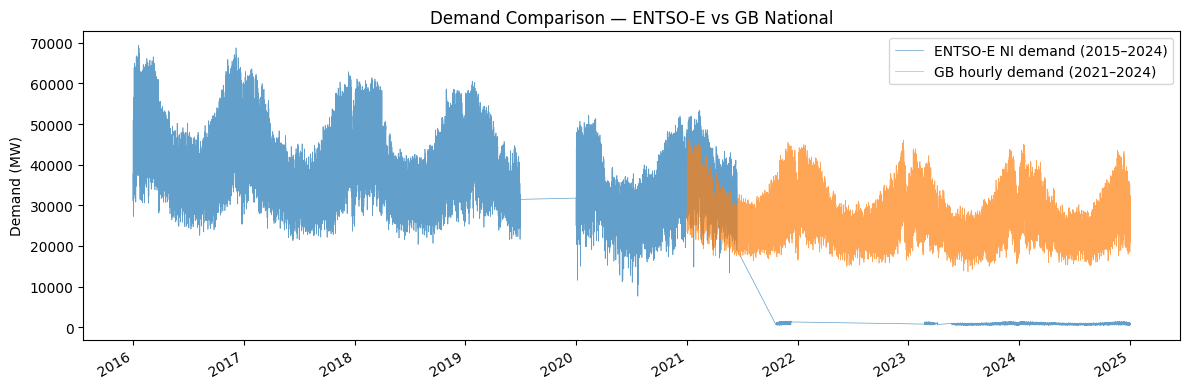

In [ ]:
# Quick visualisation — GB demand vs ENTSO-E (NI as example)
entsoe = pd.read_parquet(f'{DEMAND}/MHLV_2015-2024.parquet')
entsoe_ni = entsoe[entsoe['CountryCode'] == 'GB']

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(entsoe_ni['DateUTC'], entsoe_ni['Value'],
        alpha=0.7, linewidth=0.5, label='ENTSO-E GB demand (2015–2024)')
ax.plot(gb_demand['DATETIME'], gb_demand['ND'],
        alpha=0.7, linewidth=0.5, label='NESO GB hourly demand (2021–2024)')
ax.set_title('Demand Comparison — ENTSO-E vs GB National')
ax.set_ylabel('Demand (MW)')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()